# Install libraries

In [1]:
pip install rasterio pyproj numpy scipy

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [2]:
import rasterio
import numpy as np
from rasterio.transform import xy
from pyproj import Transformer
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import config

# Digital Elevation Model Preprocessing

In [3]:
def load_raster_data(raster_file, null_value, high_threshold, low_threshold):
    """
    Load the raster data from a file and handle null and unrealistic values.

    Parameters
    ----------
    raster_file : str
        Path to the raster file.
    null_value : int or float, optional
        Value to consider as null in the raster data (default is -9999).
    high_threshold : int or float, optional
        Threshold above which values are considered unrealistic and set to np.nan (default is 8849).
    low_threshold : int or float, optional
        Threshold below which values are considered unrealistic and set to np.nan (default is -500).

    Returns
    -------
    elevation : numpy.ndarray
        Elevation data array with null and unrealistic values handled.
    transform : affine.Affine
        Affine transformation for the raster.
    crs : rasterio.crs.CRS
        Coordinate reference system of the raster.

    Notes
    -----
    The high_threshold is set to 8849 meters, which corresponds to the height of Mt. Everest, the highest point on Earth.
    The low_threshold is set to -500 meters, which is a depth representing very deep waters far from the coast.
    Any value beyond these thresholds is considered unrealistic and set to np.nan.
    """
    with rasterio.open(raster_file) as dataset:
        elevation = dataset.read(1)
        transform = dataset.transform
        crs = dataset.crs
    
    print(f"Initial elevation min value: {np.nanmin(elevation)}")
    print(f"Initial elevation max value: {np.nanmax(elevation)}")

    elevation[elevation == null_value] = np.nan
    elevation[elevation > high_threshold] = np.nan
    elevation[elevation < low_threshold] = np.nan

    print(f"Updated elevation min value: {np.nanmin(elevation)}")
    print(f"Updated elevation max value: {np.nanmax(elevation)}")

    return elevation, transform, crs


In [4]:
def transform_coordinates(elevation, transform, crs_from, crs_to):
    """
    Transform grid coordinates from one CRS to another, in this case, to EPSG:4326 (Decimal Degrees)

    Parameters
    ----------
    elevation : numpy.ndarray
        Elevation data array.
    transform : affine.Affine
        Affine transformation for the raster.
    crs_from : str
        Coordinate reference system of the input coordinates.
    crs_to : str, optional
        Coordinate reference system of the output coordinates (default is 'epsg:4326' for WGS 84).

    Returns
    -------
    longitude : numpy.ndarray
        Transformed longitude coordinates.
    latitude : numpy.ndarray
        Transformed latitude coordinates.
    """
    cols, rows = np.meshgrid(np.arange(elevation.shape[1]), np.arange(elevation.shape[0]))
    lon, lat = rasterio.transform.xy(transform, rows, cols, offset='center')
    transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
    lon_flat, lat_flat = transformer.transform(np.array(lon).flatten(), np.array(lat).flatten())
    longitude = lon_flat.reshape(elevation.shape)
    latitude = lat_flat.reshape(elevation.shape)

    print("New Coordinate Reference System of DEM in PyFlood:", crs_to)
    return longitude, latitude

In [5]:
def save_data(elevation, longitude, latitude, filename=config.dem_file_path):
    """
    Save the data to a .mat file with compression.

    Parameters
    ----------
    elevation : numpy.ndarray
        Elevation data array.
    longitude : numpy.ndarray
        Longitude coordinates array.
    latitude : numpy.ndarray
        Latitude coordinates array.
    filename : str, optional
        Name of the .mat file to save (default is 'DEM.mat').

    Returns
    -------
    None
    """
    data = {
        'z': elevation,
        'lon': longitude,
        'lat': latitude
    }
    savemat(filename, data, do_compression=True)

In [6]:
# Example usage
elevation, transform, crs = load_raster_data(
    config.raster_file_path, 
    null_value=config.null_value, 
    high_threshold=config.high_threshold, 
    low_threshold=config.low_threshold
)

print("Original Coordinate Reference System of DEM:", crs)

longitude, latitude = transform_coordinates(elevation, transform, crs, config.crs_to)

save_data(elevation[config.start_row:config.end_row, config.start_col:config.end_col], 
          longitude[config.start_row:config.end_row, config.start_col:config.end_col], 
          latitude[config.start_row:config.end_row, config.start_col:config.end_col])

Initial elevation min value: -21.036678314208984
Initial elevation max value: 3.3999999521443642e+38
Updated elevation min value: -21.036678314208984
Updated elevation max value: 57.049835205078125
Original Coordinate Reference System of DEM: EPSG:4269
New Coordinate Reference System of DEM in PyFlood: epsg:4326


In [7]:
def plot_dem_from_mat(file_path):
    """
    Read DEM data from a .mat file and plot it, handling nan values properly.

    Parameters
    ----------
    file_path : str
        Path to the .mat file containing DEM data.

    Returns
    -------
    None
    """
    # Load the .mat file
    data = loadmat(file_path)
    
    # Extract elevation, longitude, and latitude data
    elevation = data.get('z')
    longitude = data.get('lon')
    latitude = data.get('lat')
    
    if elevation is None or longitude is None or latitude is None:
        raise ValueError("The .mat file does not contain 'z', 'lon', or 'lat' variables.")
    
    # Print the shapes of the elevation, latitude, and longitude arrays
    print(f"Shape of elevation: {elevation.shape}")
    print(f"Shape of longitude: {longitude.shape}")
    print(f"Shape of latitude: {latitude.shape}")
    
    # Check for consistency in shapes
    if elevation.shape != longitude.shape or elevation.shape != latitude.shape:
        raise ValueError("The shapes of 'z', 'lon', and 'lat' arrays are not consistent.")
    
    # Display the initial maximum and minimum values of the elevation data
    print(f"Elevation min value: {np.nanmin(elevation)}")
    print(f"Elevation max value: {np.nanmax(elevation)}")
    
    # Plot the DEM
    plt.figure(figsize=(8, 8))
    plt.imshow(elevation, cmap='terrain', extent=(np.nanmin(longitude), np.nanmax(longitude), np.nanmin(latitude), np.nanmax(latitude)))
    plt.colorbar(label='Elevation')
    plt.title('DEM Map')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

Shape of elevation: (15250, 14000)
Shape of longitude: (15250, 14000)
Shape of latitude: (15250, 14000)
Elevation min value: -21.036678314208984
Elevation max value: 26.351070404052734


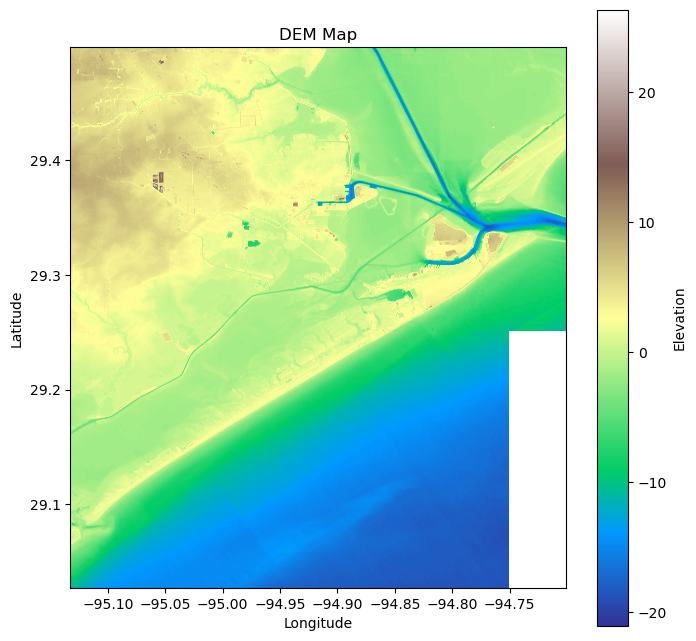

In [8]:
# Plot the DEM from the saved .mat file
plot_dem_from_mat(config.dem_file_path)

# Land Cover Data Preprocessing

In [9]:
def process_land_cover(raster_file, dem_file, null_value, high_threshold, low_threshold, filename):
    """
    Process the land cover classification from a raster file and save it to a .mat file.

    Parameters
    ----------
    raster_file : str
        Path to the raster file containing land cover classification.
    dem_file : str
        Path to the DEM file to extract default slicing values.
    null_value : int or float, optional
        Value to consider as null in the raster data (default is -9999).
    high_threshold : int or float, optional
        Threshold above which values are considered unrealistic and set to np.nan (default is 23).
    low_threshold : int or float, optional
        Threshold below which values are considered unrealistic and set to np.nan (default is 2).

    Returns
    -------
    None
    """
    with rasterio.open(raster_file) as dataset:
        land_cover = dataset.read(1)
        transform = dataset.transform
        crs = dataset.crs
    
    land_cover = land_cover.astype(float)
    land_cover[land_cover == null_value] = np.nan
    land_cover[land_cover > high_threshold] = np.nan
    land_cover[land_cover < low_threshold] = np.nan

    print(f"Initial land cover min ID value: {np.nanmin(land_cover)}")
    print(f"Initial land cover max ID value: {np.nanmax(land_cover)}")

    unique_values, counts = np.unique(land_cover, return_counts=True)
    value_counts = dict(zip(unique_values, counts))
    for value, count in value_counts.items():
        print("Value:", value, "- Count:", count)

    with rasterio.open(dem_file) as dem_dataset:
        dem_shape = dem_dataset.read(1).shape
        start_row, end_row = config.start_row, config.end_row
        start_col, end_col = config.start_col, config.end_col

    processed_shape = land_cover[start_row:end_row, start_col:end_col].shape
    data = {'land_cover': land_cover[start_row:end_row, start_col:end_col]}
    savemat(filename, data, do_compression=True)

    plt.figure(figsize=(10, 6))
    plt.imshow(land_cover[start_row:end_row, start_col:end_col], cmap='tab20', extent=(transform[2], transform[2] + transform[0] * land_cover.shape[1], transform[5] + transform[4] * land_cover.shape[0], transform[5]))
    plt.colorbar(label='Land Cover Class IDs')
    plt.title('Processed Land Cover Map')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

Initial land cover min ID value: 2.0
Initial land cover max ID value: 23.0
Value: 2.0 - Count: 1107270
Value: 3.0 - Count: 4554373
Value: 4.0 - Count: 24447081
Value: 5.0 - Count: 8136076
Value: 6.0 - Count: 10656120
Value: 7.0 - Count: 9749669
Value: 8.0 - Count: 5505525
Value: 9.0 - Count: 26915897
Value: 10.0 - Count: 672138
Value: 11.0 - Count: 156638
Value: 12.0 - Count: 11432918
Value: 13.0 - Count: 1654078
Value: 14.0 - Count: 1058693
Value: 15.0 - Count: 13282648
Value: 16.0 - Count: 4696
Value: 17.0 - Count: 283
Value: 18.0 - Count: 15290972
Value: 19.0 - Count: 1492881
Value: 20.0 - Count: 349594
Value: 21.0 - Count: 222217143
Value: 22.0 - Count: 94658
Value: 23.0 - Count: 15917
Value: nan - Count: 102303932


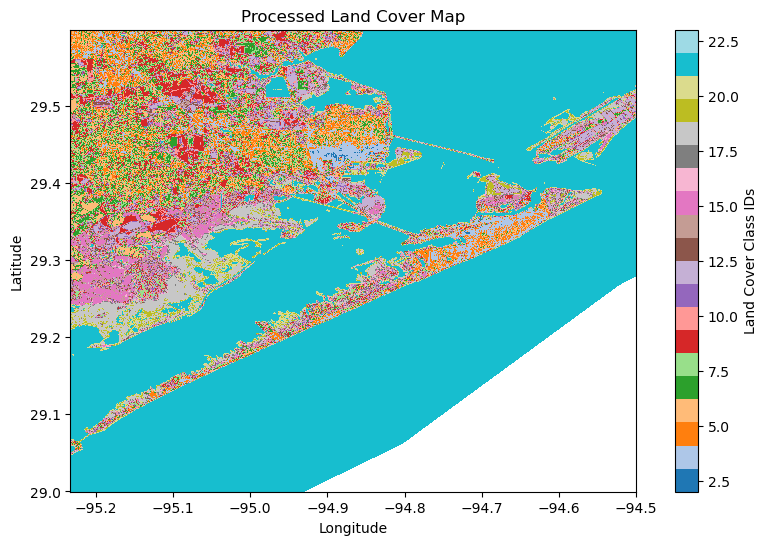

In [10]:
# Example usage
process_land_cover(config.land_cover_raster_file, config.raster_file_path, 
                   null_value=config.land_cover_null_value, 
                   high_threshold=config.land_cover_high_threshold, 
                   low_threshold=config.land_cover_low_threshold,
                   filename=config.land_cover_file_path)